## Part I: Model Setup & Train

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
import random

torch.cuda.empty_cache()

In [2]:
# Define constants
EMBEDDING_DIM = 16
HIDDEN_DIM = 16
LATENT_DIM = 16 # Dimension of the latent space
SEQ_LEN = 16 # Max length of the sequence
NHEAD = 2
NUM_LAYERS = 2

# Gumbel softmax temperature
TAU = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.random.manual_seed(1024)

In [3]:
# Pass embeded into decoder instead of using the original x
class TransformerEncoder(nn.Module):
    def __init__(self, d_model=EMBEDDING_DIM, nhead=NHEAD, num_layers=NUM_LAYERS):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            # multi-head attention, fead-forward net
            nn.TransformerEncoderLayer(d_model, nhead), num_layers 
        )
        self.fc_logits = nn.Linear(d_model, LATENT_DIM)

    def forward(self, x):
        embedded = self.embedding(x).permute(1, 0, 2)  # Transformer expects seq_len, batch, features
        transformed = self.transformer_encoder(embedded)
        # Use the final state to predict logits for latent space
        logits = self.fc_logits(transformed[-1])
        return logits, embedded


class TransformerDecoder(nn.Module):
    def __init__(self, d_model=EMBEDDING_DIM, nhead=NHEAD, num_layers=NUM_LAYERS):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead), num_layers
        )
        self.fc_out = nn.Linear(d_model, VOCAB_SIZE)
        self.fc_z = nn.Linear(LATENT_DIM, d_model)  # Convert z to feature size for transformer

    def forward(self, embedded, z):
        # embedded = self.embedding(x).permute(1, 0, 2) # Transformer expects [seq_len, batch, features], permute函数用于改变张量的维度顺序
        z_adjusted = self.fc_z(z).unsqueeze(0)
        output = self.transformer_decoder(embedded, z_adjusted)
        return self.fc_out(output.permute(1, 0, 2))


class TransformerCVAE(nn.Module):
    def __init__(self):
        super(TransformerCVAE, self).__init__()
        self.encoder = TransformerEncoder()
        self.decoder = TransformerDecoder()

    def reparameterize(self, logits):
        return F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1)

    def forward(self, x):
        logits, emb = self.encoder(x)
        z = self.reparameterize(logits)
        return self.decoder(emb, z), logits

In [4]:
def load_and_preprocess_wikitext(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    # Use regular expressions to split the text into sentences
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [sentence.strip() for sentence in sentences]
    
    return sentences

train_file_path = "wikitext-2/wiki.train.tokens"
test_file_path = "wikitext-2/wiki.test.tokens"
val_file_path = "wikitext-2/wiki.valid.tokens"

wikitext_sentences_train = load_and_preprocess_wikitext(train_file_path)
wikitext_sentences_test = load_and_preprocess_wikitext(test_file_path)
wikitext_sentences_val = load_and_preprocess_wikitext(val_file_path)

# Print the first few sentences to check
print("\nSample of train sentences:")
print(wikitext_sentences_train[:5])
print("\nSample of test sentences:")
print(wikitext_sentences_test[:5])
print("\nSample of val sentences:")
print(wikitext_sentences_val[:5])


Sample of train sentences:
['= Valkyria Chronicles III = \n \n Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit .', 'Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable .', 'Released in January 2011 in Japan , it is the third game in the Valkyria series .', '<unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " .', 'The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II .']

Sample of test sentences:
['= Robert <unk> = \n \n Robert <unk> is an English film , television and theatre actor .',

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

# Hyperparameters
BATCH_SIZE = 16
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

# Tokenize the data
tokens = [word for sentence in wikitext_sentences_train for word in sentence.split()]

# Build vocabulary
vocab = [PAD_TOKEN, UNK_TOKEN] + list(set(tokens))
word_index = {word: index for index, word in enumerate(vocab)}
# 添加新的tokens
SOS_TOKEN = '<SOS>'
EOS_TOKEN = '<EOS>'
word_index[SOS_TOKEN] = len(word_index)
word_index[EOS_TOKEN] = len(word_index)
vocab = {v: k for k, v in word_index.items()}
# Convert tokens to integers
def tokenize_and_encode(text):
    return [word_index.get(word, word_index[UNK_TOKEN]) for word in text.split()]

encoded_data_train = [tokenize_and_encode(sentence) for sentence in wikitext_sentences_train]

# Create a PyTorch Dataset
class WikiDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if len(sample) < self.sequence_length:
            sample.extend([word_index[PAD_TOKEN]] * (self.sequence_length - len(sample)))
        else:
            sample = sample[:self.sequence_length]
        return torch.tensor(sample)

# dataset = WikiDataset(encoded_data_train, SEQUENCE_LENGTH)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
# Split the data into train and validation sets
dataset = WikiDataset(encoded_data_train, SEQ_LEN)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Display a sample batch
print(next(iter(train_dataloader)))

VOCAB_SIZE = len(vocab)
print(f'Vocabulary size: {VOCAB_SIZE}')


tensor([[ 8654, 29601,  2261,   525, 29601, 13930, 18511, 12429, 15329, 24512,
         25406,  8775, 18511, 31183,  5352, 32887],
        [23039, 11951, 11953, 15329, 29601, 13596,   525, 26583, 28942, 29601,
         12212, 30327,   525,  8304, 12556, 15050],
        [17267,  7254, 30312, 29601, 26177,  2045, 18511, 28340,  6608, 11229,
          9651, 11229, 18511, 24330, 29208,     0],
        [11943, 11229, 16139,  5382, 10678, 29601, 13412, 27904,   525,  6837,
         15329, 29601, 21665,   525, 29601,  2975],
        [29181,  1854, 22698,  6608, 24769,   864, 21078, 20748, 10268, 31966,
         25805, 27264, 28447, 28998, 27199,  8571],
        [27851, 32862, 27305, 25406, 27026, 11816, 27199, 12308, 27199, 15329,
          5588, 28447,   525, 28447, 13462, 27026],
        [31757, 15329, 29601, 29196, 16206,  1132, 28012,   714, 17822, 31468,
           525, 17615, 27334,  8478, 27026, 17615],
        [16760, 29601, 27454,   525, 28420, 10290, 10039,  7357, 29932,  6608,
    

In [6]:
# Initializing the model with the set hyperparameters
transformer_cvae = TransformerCVAE()
transformer_cvae.to(device)

# Define the loss function and the optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer_cvae.parameters(), lr=1e-3)

Epoch 1/3 | Loss: 2.1682243 = Recon: 2.1681833 + KLD: 0.0000410:  33%|███▎      | 3928/11784 [00:56<01:51, 70.52it/s]  

Input: There were several variants of the <unk> design . ---> Echo: There were several upon of the <unk> design .



Epoch 2/3 | Loss: 0.1416055 = Recon: 0.1416039 + KLD: 0.0000016:  67%|██████▋   | 7856/11784 [01:52<00:52, 74.20it/s]

Input: There were several variants of the <unk> design . ---> Echo: There were several variants of the <unk> design .



Epoch 3/3 | Loss: 0.0357896 = Recon: 0.0357886 + KLD: 0.0000010: 100%|██████████| 11784/11784 [02:48<00:00, 73.52it/s]

Input: There were several variants of the <unk> design . ---> Echo: There were several variants of the <unk> design .



Epoch 3/3 | Loss: 0.0357896 = Recon: 0.0357886 + KLD: 0.0000010: 100%|██████████| 11784/11784 [02:51<00:00, 68.90it/s]


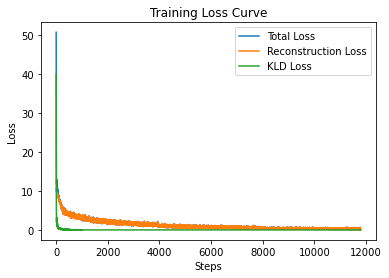

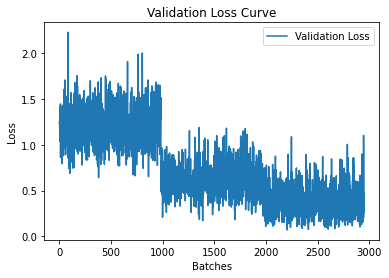

In [7]:
def generate_text(model, sentence, vocab):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Tokenize and encode the sentence
        encoded_sentence = tokenize_and_encode(sentence)
        input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)  # Ensure type is Long
        
        # Pass the encoded sentence through the model encoder
        with torch.no_grad():
            logits, emb = model.encoder(input_tensor)
            z = model.reparameterize(logits)
            output = model.decoder(emb, z)
        
        # Convert the output probabilities to predicted token IDs
        _, predicted_ids = torch.max(output, dim=2)
        predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
        # Convert the predicted token IDs back to words
        predicted_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        
        return predicted_sentence

def combined_loss_fn(recon_output, target, logits, beta=1.0):
    # 计算重构损失
    # recon_output = torch.clamp(recon_output, 1e-10, 1 - 1e-10)
    recon_loss = F.cross_entropy(recon_output.view(-1, VOCAB_SIZE), target.view(-1), reduction='mean')

    # 计算KLD损失
    mean, logvar = torch.chunk(logits, 2, dim=-1)
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # 计算总损失
    total_loss = recon_loss + beta * kld_loss

    return total_loss, recon_loss, kld_loss


valid_sentence = "There were several variants of the <unk> design ."

def train_and_visualize(model, train_dataloader, val_dataloader, optimizer, num_epochs, word_index, vocab, beta=1.0):
    losses = []
    val_losses = []
    recon_losses = []
    kld_losses = []
    total_steps = len(train_dataloader) * num_epochs

    # Initialize tqdm progress bar
    progress_bar = tqdm(total=total_steps, desc="Training", position=0)

    for epoch in range(num_epochs):
        for batch in train_dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output, logits = model(batch)
            
            # 使用新的损失函数
            loss, recon_loss, kld_loss = combined_loss_fn(output, batch, logits, beta)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            losses.append(loss.item())
            recon_losses.append(recon_loss.item())
            kld_losses.append(kld_loss.item())
            progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.7f} = Recon: {recon_loss.item():.7f} + KLD: {kld_loss.item():.7f}')
            progress_bar.update(1)

        # Generate text after each epoch
        generated_sentence = generate_text(model, valid_sentence, vocab)
        print(f"Input: {valid_sentence} ---> Echo: {generated_sentence}\n")
        
        # Print epoch loss
        avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        # print(f"Done Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.7f}")

        # Validation after each epoch
        model.eval()
        with torch.no_grad():
            avg_val_loss = 0
            for batch in val_dataloader:
                batch = batch.to(device)
                output, logits = model(batch)
                val_loss, _, _ = combined_loss_fn(output, batch, logits, beta)
                val_losses.append(val_loss.item())
                avg_val_loss += val_loss.item()
            avg_val_loss /= len(val_dataloader)
            # print(f"Done Epoch [{epoch+1}/{num_epochs}] - Validation Loss: {avg_val_loss:.7f}")

        

    # Close the tqdm progress bar
    progress_bar.close()
    
    torch.save(transformer_cvae.state_dict(), 'transformer_cvae.dict')

    # Plot the loss curve
    plt.plot(losses, label='Total Loss')
    plt.plot(recon_losses, label='Reconstruction Loss')
    plt.plot(kld_losses, label='KLD Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    # Plot the validation loss curve
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.title('Validation Loss Curve')
    plt.legend()
    plt.show()

num_epochs = 3
train_and_visualize(transformer_cvae, train_dataloader, val_dataloader, optimizer, num_epochs, word_index, vocab)

In [8]:
valid_sentence = "Robert <unk> is an English film , television and theatre actor ."
test_generate = generate_text(transformer_cvae, valid_sentence, vocab)
test_generate

'Robert <unk> is an English film , television and theatre actor .'

In [9]:
# # Visualize the latent space (t-SNE)
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# def visualize_latent_space(model, dataloader, device):
#     model.eval()
    
#     # Collect logits from the encoder
#     logits_list = []
#     with torch.no_grad():
#         for batch in dataloader:
#             batch = batch.to(device)
#             logits, _ = model.encoder(batch)
#             logits_list.append(logits)
    
#     logits_array = torch.cat(logits_list).cpu().numpy()

#     # Perform t-SNE
#     tsne = TSNE(n_components=2)
#     logits_2d = tsne.fit_transform(logits_array)

#     # Plot
#     plt.figure(figsize=(10, 10))
#     plt.scatter(logits_2d[:, 0], logits_2d[:, 1], alpha=0.5)
#     plt.title("t-SNE visualization of logits")
#     plt.show()

# # After training, call the visualization function
# visualize_latent_space(transformer_cvae, train_dataloader, device)


## Part II: 'Signal Game'

 Round[10000/10000] loss: 0.1224908: 100%|██████████| 10000/10000 [01:57<00:00, 85.35it/s]


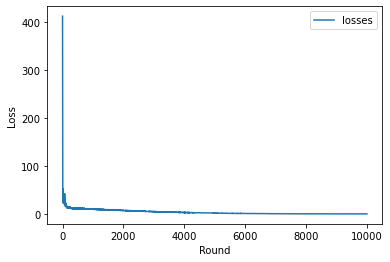

In [10]:
import torch.nn.functional as F

class SignalingGame:
    def __init__(self, sender: TransformerEncoder, receiver: TransformerDecoder, optimizer, criterion):
        self.sender = sender
        self.receiver = receiver
        self.optimizer = optimizer
        self.criterion = criterion

    def play_round(self, state):
        # # Convert the state to predicted token IDs
        # predicted_ids_batch = state.cpu().numpy()
        # for i in range(predicted_ids_batch.shape[0]):
        #     predicted_ids = predicted_ids_batch[i]
        #     # Convert the predicted token IDs back to words
        #     state_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        #     print(f'state_sentence_{i}:{state_sentence}')
        
        # 发信者编码状态
        logits, emb = self.sender(state)
        z = F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1)
        
        # 接收者解码信号
        decoded_output = self.receiver(emb, z)
      
        # # Convert the output probabilities to predicted token IDs
        # _, predicted_ids_batch = torch.max(decoded_output, dim=2)
        # predicted_ids_batch = predicted_ids_batch.cpu().numpy()
        # for i in range(predicted_ids_batch.shape[0]):
        #     predicted_ids = predicted_ids_batch[i]
        #     # Convert the predicted token IDs back to words
        #     decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        #     print(f'decoded_sentence_{i}:{decoded_sentence}')
        
        # 计算损失
        loss = self.compute_loss(state, decoded_output, logits, beta = 10.0)
        
        # 更新模型参数
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def compute_loss(self, original_state, decoded_state, logits, beta):
        recon_loss = self.criterion(decoded_state.view(-1, VOCAB_SIZE), original_state.view(-1))
        # 计算KLD损失
        mean, logvar = torch.chunk(logits, 2, dim=-1)
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        return recon_loss + beta * kld_loss


# 初始化发信者和接收者
sender = TransformerEncoder().to(device)
receiver = TransformerDecoder().to(device)

# 为游戏定义优化器和损失函数
optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

game = SignalingGame(sender, receiver, optimizer, criterion)

# 模拟多轮信号游戏
num_rounds = 10000
losses = []
progress_bar = tqdm(total=num_rounds, desc="Playing rounds")
for round in range(num_rounds):
    state = torch.randint(VOCAB_SIZE, (BATCH_SIZE, 16)).to(device)  # 随机生成一个batch的16词长度的句子作为状态
    loss = game.play_round(state)
    losses.append(loss)
    progress_bar.set_description(f' Round[{round+1}/{num_rounds}] loss: {loss:.7f}')
    progress_bar.update()
progress_bar.close()
# 绘制损失曲线
import matplotlib.pyplot as plt
plt.plot(losses, label='losses')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
# class SignalingGameModified:
#     def __init__(self, sender: TransformerEncoder, receiver: TransformerDecoder, optimizer, criterion):
#         self.sender = sender
#         self.receiver = receiver
#         self.optimizer = optimizer
#         self.criterion = criterion

#     def play_round(self, state):
#         # Sender encodes the state
#         logits, emb = self.sender(state)
#         z = F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1)
        
#         # Receiver decodes the signal from the sender
#         decoded_output = self.receiver(emb, z)
      
#         # Calculate loss
#         total_loss, recon_loss, kld_loss = self.compute_loss(state, decoded_output, logits, beta=10.0)
        
#         # Update model parameters
#         self.optimizer.zero_grad()
#         total_loss.backward()
#         self.optimizer.step()

#         return total_loss.item(), recon_loss.item(), kld_loss.item()

#     def compute_loss(self, original_state, decoded_state, logits, beta):
#         recon_loss = self.criterion(decoded_state.view(-1, VOCAB_SIZE), original_state.view(-1))
#         # Calculate KLD loss
#         mean, logvar = torch.chunk(logits, 2, dim=-1)
#         kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

#         return recon_loss + beta * kld_loss, recon_loss, kld_loss

# # Initialize senders and receivers
# sender = TransformerEncoder().to(device)
# receiver = TransformerDecoder().to(device)

# # Define optimizer and loss function for the game
# optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=0.001)
# criterion = torch.nn.CrossEntropyLoss()

# game = SignalingGameModified(sender, receiver, optimizer, criterion)

# # Simulate multiple rounds of the signaling game
# num_rounds = 10000
# total_losses = []
# recon_losses = []
# kld_losses = []
# recorded_sentences = []

# progress_bar = tqdm(total=num_rounds, desc="Playing rounds")
# for round in range(num_rounds):
#     state = torch.randint(VOCAB_SIZE, (BATCH_SIZE, 16)).to(device)  # Randomly generate a batch of 16-word sentences as state
#     total_loss, recon_loss, kld_loss = game.play_round(state)
    
#     total_losses.append(total_loss)
#     recon_losses.append(recon_loss)
#     kld_losses.append(kld_loss)
    
#     # Record sentences every 1/10 rounds
#     if round % (num_rounds // 10) == 0:
#         predicted_ids_batch = state.cpu().numpy()
#         for i in range(predicted_ids_batch.shape[0]):
#             predicted_ids = predicted_ids_batch[i]
#             sentence = ' '.join([vocab[idx] for idx in predicted_ids])
#             recorded_sentences.append((round, i, sentence))
    
#     progress_bar.set_description(f' Round[{round+1}/{num_rounds}] Total Loss: {total_loss:.7f}, Recon Loss: {recon_loss:.7f}, KLD Loss: {kld_loss:.7f}')
#     progress_bar.update()
# progress_bar.close()

# # Plot the loss curves
# plt.figure(figsize=(12, 6))
# plt.plot(total_losses, label='Total Loss')
# plt.plot(recon_losses, label='Recon Loss')
# plt.plot(kld_losses, label='KLD Loss')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# recorded_sentences[:10]  # Displaying first 10 recorded sentences for brevity


 Round[10000/10000] loss: 0.1463954: 100%|██████████| 10000/10000 [01:57<00:00, 85.26it/s]


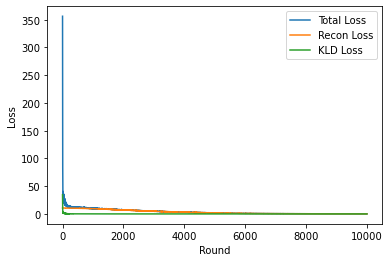

Input Sentence: 1894 census Large Pop Greenwich champions Fulfilled spreads 900 operated transcendent AIR consequences Jobs 3s scholarly
Decoded Sentence: suppliers Blanc mum ribbon Sage Stela Incident Hypacrosaurus fulfill Nekoi Jakarta Sinai gale Anders terrorists riddle
--------------------------------------------------
Input Sentence: element restaurant saddle Bypass Hindu Palabras dinosaur bootleg appeal garner collateral Regarding tensile fertilised predicts greatness
Decoded Sentence: Antarctic Lyrically Antarctic Consistory turrets beautifully Metre sago César baseline 1840s Methods camphor Naminé Alexandra center
--------------------------------------------------
Input Sentence: uncut ethics Garza 143 Honorary zoo assume Keshiraja Kathleen uncertainty Lennie hardcover Blonde Parachute newcomers culminating
Decoded Sentence: undisclosed dialog leaving NC 1345 Baseball Dimitri Keshiraja Farrell favorite Kirkus Berger m2 Kovacs Boise express
--------------------------------------

In [12]:
import torch.nn.functional as F

class SignalingGame:
    def __init__(self, sender: TransformerEncoder, receiver: TransformerDecoder, optimizer, criterion):
        self.sender = sender
        self.receiver = receiver
        self.optimizer = optimizer
        self.criterion = criterion

    def play_round(self, state):
        # Sender encodes the state
        logits, emb = self.sender(state)
        z = F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1)
        
        # Receiver decodes the signal from the sender
        decoded_output = self.receiver(emb, z)
        
        # Calculate loss
        loss, recon_loss, kld_loss = self.compute_loss(state, decoded_output, logits, beta=10.0)
        
        # Update model parameters
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item(), recon_loss.item(), kld_loss.item(), decoded_output

    def compute_loss(self, original_state, decoded_state, logits, beta):
        recon_loss = self.criterion(decoded_state.view(-1, VOCAB_SIZE), original_state.view(-1))
        
        # Calculate KLD loss
        mean, logvar = torch.chunk(logits, 2, dim=-1)
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        return recon_loss + beta * kld_loss, recon_loss, kld_loss

# Initialize sender and receiver
sender = TransformerEncoder().to(device)
receiver = TransformerDecoder().to(device)

# Define optimizer and loss function for the game
optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

game = SignalingGame(sender, receiver, optimizer, criterion)

# Simulate multiple rounds of the signaling game
num_rounds = 10000
losses = []
recon_losses = []
kld_losses = []
sentences = []

progress_bar = tqdm(total=num_rounds, desc="Playing rounds")
for round in range(num_rounds):
    state = torch.randint(VOCAB_SIZE, (BATCH_SIZE, 16)).to(device)  # Randomly generate a batch of 16-word length sentences as state
    
    loss, recon_loss, kld_loss, decoded_output = game.play_round(state)
    losses.append(loss)
    recon_losses.append(recon_loss)
    kld_losses.append(kld_loss)
    
    progress_bar.set_description(f' Round[{round+1}/{num_rounds}] loss: {loss:.7f}')
    progress_bar.update()
    
    if round % (num_rounds // 10) == 0:
        # Convert the state to predicted token IDs for recording
        predicted_ids = state[0].cpu().numpy()  # Only take the first sentence for simplicity
        state_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        
        # Convert the decoded output to predicted token IDs
        _, predicted_ids = torch.max(decoded_output[0], dim=1)  # Only take the first decoded sentence for simplicity
        predicted_ids = predicted_ids.cpu().numpy()
        decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
        
        sentences.append((state_sentence, decoded_sentence))

progress_bar.close()

# Plot the loss curves
import matplotlib.pyplot as plt
plt.plot(losses, label='Total Loss')
plt.plot(recon_losses, label='Recon Loss')
plt.plot(kld_losses, label='KLD Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print recorded sentences
for state_sentence, decoded_sentence in sentences:
    print(f"Input Sentence: {state_sentence}")
    print(f"Decoded Sentence: {decoded_sentence}")
    print("-" * 50)


 Round[10000/10000] loss: 66.8778000: 100%|██████████| 10000/10000 [09:33<00:00, 17.42it/s]


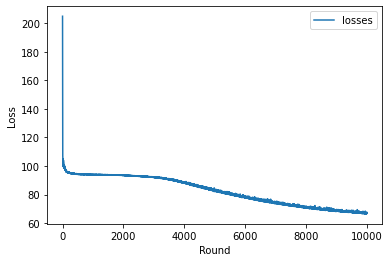

In [13]:
import torch.nn.functional as F

class MultiMultiSignalingGame:
    def __init__(self, senders: list, receivers: list, optimizer, criterion):
        self.senders = senders
        self.receivers = receivers
        self.optimizer = optimizer
        self.criterion = criterion

    def play_round(self, states):
        all_decoded_outputs = []
        all_logits = []
        
        for i, sender in enumerate(self.senders):
            # Sender encodes the state
            logits, emb = sender(states[i])
            all_logits.append(logits)
            z = F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1)
            
            # Each receiver decodes the signal from the sender
            for receiver in self.receivers:
                decoded_output = receiver(emb, z)
                all_decoded_outputs.append(decoded_output)
      
        # Calculate loss
        loss = self.compute_loss(states, all_decoded_outputs, all_logits, beta=1.0)
        
        # Update model parameters
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def compute_loss(self, original_states, decoded_states, logits, beta):
        recon_loss = sum([self.criterion(decoded_state.view(-1, VOCAB_SIZE), original_state.view(-1))
                          for original_state, decoded_state in zip(original_states * len(self.receivers), decoded_states)])
        
        # Calculate KLD loss
        kld_losses = []
        for logit in logits:
            mean, logvar = torch.chunk(logit, 2, dim=-1)
            kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
            kld_losses.append(kld_loss)

        return recon_loss + beta * sum(kld_losses)


# Initialize senders and receivers
NUM_SENDERS = 3
NUM_RECEIVERS = 3
senders = [TransformerEncoder().to(device) for _ in range(NUM_SENDERS)]
receivers = [TransformerDecoder().to(device) for _ in range(NUM_RECEIVERS)]

# Define optimizer and loss function for the game
params = [list(sender.parameters()) for sender in senders]
params.extend([list(receiver.parameters()) for receiver in receivers])
optimizer = torch.optim.Adam([param for sublist in params for param in sublist], lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

game = MultiMultiSignalingGame(senders, receivers, optimizer, criterion)

# Simulate multiple rounds of the signaling game
num_rounds = 10000
losses = []
progress_bar = tqdm(total=num_rounds, desc="Playing rounds")
for round in range(num_rounds):
    states = [torch.randint(VOCAB_SIZE, (BATCH_SIZE, 16)).to(device) for _ in range(NUM_SENDERS)]
    loss = game.play_round(states)
    losses.append(loss)
    progress_bar.set_description(f' Round[{round+1}/{num_rounds}] loss: {loss:.7f}')
    progress_bar.update()
progress_bar.close()

# Plot the loss curve
import matplotlib.pyplot as plt
plt.plot(losses, label='losses')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# class Agent:
#     def __init__(self, model, id):
#         self.model = model
#         self.id = id
#         self.influence = 1.0
#         self.lifespan = 3
#         self.age = 0
#         self.alive = True

#     def send(self, input_tensor):
        
#         # Use the encoder to encode the sentence
#         logits, embed = self.model.encoder(input_tensor)
#         msg = self.model.reparameterize(logits)
#         return msg, embed, logits

#     def receive(self, msg, embed):
#         # Use the decoder to decode the message
#         decoded_output = self.model.decoder(embed, msg)
        
#         # Convert the output probabilities to predicted token IDs
#         _, predicted_ids = torch.max(decoded_output, dim=2)
        
# #         predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
# #         # Convert the predicted token IDs back to words
# #         decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
#         # Convert the predicted token IDs back to words
#         predicted_ids_list = predicted_ids.ravel().tolist()
#         decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids_list])


#         return decoded_output, decoded_sentence

#     def age_one_year(self):
#         self.age += 1
#         if self.age >= self.lifespan:
#             self.alive = False
            

# def simulation(num_generations=10, initial_population=10):
#     # population = [Agent(transformer_cvae.to(device), id=i) for i in range(initial_population)]
#     pretrained_model_path = 'transformer_cvae.dict'
#     population = []
#     for i in range(initial_population):
#         agent_model = TransformerCVAE().to(device)
#         agent_model.load_state_dict(torch.load(pretrained_model_path))
#         population.append(Agent(agent_model, id=i))
#     history = []
    
#     scaler = GradScaler()  # Initialize the gradient scaler

#     for generation in range(num_generations):
#         record = {
#             'generation': generation,
#             'population_size': len(population),
#             'avg_influence': sum([agent.influence for agent in population]) / len(population),
#             'successful_communications': 0,
#             'exact_matches': 0,
#             'total_communications': 0,
#             'successful_communication_rate': 0,
#             'avg_loss': 0,
#             'communications': [],
#             'agents_id': [],
#         }
        
#         # Shuffle the population list to ensure randomness in agent selection
#         random.shuffle(population)

#         # Agents communicate
#         for agent in population:
#             if agent.alive:
#                 record['agents_id'].append(agent.id)
#                 optimizer_sender = torch.optim.AdamW(agent.model.parameters())
#                 # The number of times each agent communicates is proportional to its influence
#                 # num_communications = max(1, int(agent.influence * 10))
#                 num_communications = max(1, int(agent.influence ** 2))
#                 for _ in range(num_communications):
#                     exact_match = False
#                     # An agent tries to communicate with another random agent (but not itself)
#                     # others = [a for a in population if a.id != agent.id & a.alive]
#                     others = [a for a in population if (a.id != agent.id) and a.alive]
#                     influences = torch.tensor([a.influence for a in others])
#                     influences = F.normalize(influences, p=1, dim=0)
                    
#                     # Check for invalid values
#                     if torch.isnan(influences).any() or torch.isinf(influences).any() or (influences < 0).any():
#                         print("Invalid influence values detected!")
#                         for other in others:
#                             print(f"Agent {other.id} influence: {other.influence}")
#                         raise ValueError("Invalid influence values detected!")
                        
#                     idx = torch.multinomial(influences, 1).item()
#                     partner = others[idx]
#                     optimizer_receiver = torch.optim.AdamW(partner.model.parameters())
                    
#                     batch_sentence = next(iter(train_dataloader))
#                     # idx = torch.randint(0, len(sentences), (1,)).item()
#                     # sentence = sentences[idx]
#                     # Tokenize and encode the sentence
#                     # encoded_sentence = tokenize_and_encode(sentence)
#                     input_tensor = torch.tensor(batch_sentence, dtype=torch.long).to(device)
#                     with autocast():  # Enable autocast for FP16
#                         msg, emb, logit = agent.send(input_tensor)
#                         d_tensor, d_sentence = partner.receive(msg, emb)
#                         # print(f"Sender {agent.id}: {sentence} -> Receiver {partner.id}: {d_sentence}")
#                         loss,_,_ = combined_loss_fn(d_tensor, input_tensor, logit, beta=1.0)
 
#                     # Use the scaler to scale the loss and back-propagate the scaled gradients
#                     scaler.scale(loss).backward()
#                     scaler.step(optimizer_sender)
#                     scaler.step(optimizer_receiver)
#                     scaler.update()
#                     # loss.backward()
#                     # optimizer_sender.step()
#                     # optimizer_receiver.step()

#                     if loss.item() < 1.0:
#                         success = True
#                         # agent.influence = min(1.0, agent.influence + 0.1)
#                         # partner.influence = min(1.0, partner.influence + 0.1)
#                         agent.influence += 1.0
#                         partner.influence += 1.0
#                     else:
#                         success = False
#                         # agent.influence = max(0.1, agent.influence - 0.1)
#                         # partner.influence = max(0.1, partner.influence - 0.1)
#                         agent.influence -= 0.1
#                         partner.influence -= 0.1
#                         if agent.influence <= 0:
#                             agent.alive = False
#                         if partner.influence <= 0:
#                             partner.alive = False

#                     record['communications'].append({
#                         'sender': agent.id,
#                         'receiver': partner.id,
#                         'original_sentence': sentence,
#                         'decoded_sentence': d_sentence,
#                         'successful': success,
#                         'loss': loss.item(),
#                         'exact_match': exact_match,
#                     })

#                     if success:
#                         record['successful_communications'] += 1
#                     record['total_communications'] += 1
#                     record['avg_loss'] += loss.item()
#         record['successful_communication_rate'] = record['successful_communications'] / record['total_communications']
#         # print(f'total_communications: {record["total_communications"]}, num_communications: {num_communications}')
#         record['avg_loss'] /= record['total_communications']
        
#         # Ageing process
#         for agent in population:
#             agent.age_one_year()

#         # Reproduction based on influence
#         new_agents = []
#         for agent in population:
#             if agent.alive:
#                 # The number of offspring is proportional to the agent's influence
#                 num_offspring = max(1, int(agent.influence * 2))
#                 for _ in range(num_offspring):
#                     offspring_model = TransformerCVAE().to(device)
#                     # The offspring's model parameters are a copy of the parent's model parameters
#                     offspring_model.load_state_dict(agent.model.state_dict())
#                     new_agent = Agent(offspring_model, id=len(population) + len(new_agents))
#                     new_agents.append(new_agent)
        
#         # add new agents to the population
#         population.extend(new_agents)

#         history.append(record)
#         print(f"Generation [{generation+1}/{num_generations}] Done")

#     return history, population

# # 提取句子列表
# sentences = []
# for batch in train_dataloader:
#     for seq in batch:
#         sentence = ' '.join([vocab[idx.item()] for idx in seq])
#         sentences.append(sentence)
# # Call the simulation function
# history, population = simulation(num_generations=3, initial_population=2)

# # Print the history records
# for record in history:
#     print(f"Generation: {record['generation']}")
#     # print(f"Agents: {record['agents_id']}")
#     print(f"Population Size: {record['population_size']}")
#     print(f"Average Influence: {record['avg_influence']:.2f}")
#     print(f"Successful Communications: {record['successful_communications']}/{record['total_communications']}")
#     print(f"Successful Communication Rate: {record['successful_communication_rate']:.7f}")
#     print(f"Exact_Matches: {record['exact_matches']}")
#     print(f"Average Communication Loss: {record['avg_loss']:.7f}")
#     print("="*50)


In [15]:
# class Agent:
#     def __init__(self, model, id, optimizer=None):
#         self.model = model
#         self.id = id
#         self.influence = 1.0
#         self.lifespan = 3
#         self.age = 0
#         self.alive = True
#         # Assign optimizer
#         self.optimizer = optimizer if optimizer else torch.optim.AdamW(self.model.parameters(), lr=0.001)

#     def send(self, input_tensor):
        
#         # Use the encoder to encode the sentence
#         logits, embed = self.model.encoder(input_tensor)
#         msg = self.model.reparameterize(logits)
#         return msg, embed, logits

#     def receive(self, msg, embed):
#         # Use the decoder to decode the message
#         decoded_output = self.model.decoder(embed, msg)
        
#         # Convert the output probabilities to predicted token IDs
#         _, predicted_ids = torch.max(decoded_output, dim=2)
#         predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
#         # Convert the predicted token IDs back to words
#         decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
#         return decoded_output, decoded_sentence

#     def age_one_year(self):
#         self.age += 1
#         if self.age >= self.lifespan:
#             self.alive = False
            

# def simulation(num_generations=10, initial_population=10):
#     # population = [Agent(transformer_cvae.to(device), id=i) for i in range(initial_population)]
#     pretrained_model_path = 'transformer_cvae.dict'
#     population = []
    
#     base_model = TransformerCVAE().to(device)
#     base_model.load_state_dict(torch.load(pretrained_model_path))
    
#     for i in range(initial_population):
#         agent_model = copy.deepcopy(base_model)
        
#         # Add some noise to model parameters to increase diversity
#         for param in agent_model.parameters():
#             noise = torch.normal(mean=0, std=0.05, size=param.size()).to(device)
#             param.data.add_(noise)
        
#         optimizer = torch.optim.AdamW(agent_model.parameters())
#         population.append(Agent(agent_model, id=i, optimizer=optimizer))

#     history = []
#     scaler = GradScaler()  # Initialize the gradient scaler

#     for generation in range(num_generations):
#         record = {
#             'generation': generation,
#             'population_size': len(population),
#             'avg_influence': sum([agent.influence for agent in population]) / len(population),
#             'successful_communications': 0,
#             'exact_matches': 0,
#             'total_communications': 0,
#             'successful_communication_rate': 0,
#             'avg_loss': 0,
#             'communications': [],
#             'agents_id': [],
#         }
        
#         # Shuffle the population list to ensure randomness in agent selection
#         random.shuffle(population)

#         # Agents communicate
#         for agent in population:
#             if agent.alive:
#                 record['agents_id'].append(agent.id)
#                 # The number of times each agent communicates is proportional to its influence
#                 # num_communications = max(1, int(agent.influence * 10))
#                 num_communications = max(1, int(agent.influence ** 2))
#                 for _ in range(num_communications):
#                     exact_match = False
#                     # An agent tries to communicate with another random agent (but not itself)
#                     # others = [a for a in population if a.id != agent.id & a.alive]
#                     others = [a for a in population if (a.id != agent.id) and a.alive]
#                     influences = torch.tensor([a.influence for a in others])
#                     influences = F.normalize(influences, p=1, dim=0)
                    
#                     # Check for invalid values
#                     if torch.isnan(influences).any() or torch.isinf(influences).any() or (influences < 0).any():
#                         print("Invalid influence values detected!")
#                         for other in others:
#                             print(f"Agent {other.id} influence: {other.influence}")
#                         raise ValueError("Invalid influence values detected!")
                        
#                     idx = torch.multinomial(influences, 1).item()
#                     partner = others[idx]

#                     idx = torch.randint(0, len(sentences), (1,)).item()
#                     sentence = sentences[idx]
#                     # Tokenize and encode the sentence
#                     encoded_sentence = tokenize_and_encode(sentence)
#                     input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)
#                     with autocast():  # Enable autocast for FP16
#                         msg, emb, logit = agent.send(input_tensor)
#                         d_tensor, d_sentence = partner.receive(msg, emb)
#                         # print(f"Sender {agent.id}: {sentence} -> Receiver {partner.id}: {d_sentence}")
#                         loss,_,_ = combined_loss_fn(d_tensor, input_tensor, logit, beta=1.0)
 
#                     # Use the scaler to scale the loss and back-propagate the scaled gradients
#                     scaler.scale(loss).backward()
#                     scaler.step(agent.optimizer)
#                     scaler.step(partner.optimizer)
#                     scaler.update()
#                     # loss.backward()
#                     # optimizer_sender.step()
#                     # optimizer_receiver.step()

#                     if loss.item() < 0.1:
#                         success = True
#                         # agent.influence = min(1.0, agent.influence + 0.1)
#                         # partner.influence = min(1.0, partner.influence + 0.1)
#                         agent.influence += 1.0
#                         partner.influence += 1.0
#                     else:
#                         success = False
#                         # agent.influence = max(0.1, agent.influence - 0.1)
#                         # partner.influence = max(0.1, partner.influence - 0.1)
#                         agent.influence -= 0.1
#                         partner.influence -= 0.1
#                         if agent.influence <= 0:
#                             agent.alive = False
#                         if partner.influence <= 0:
#                             partner.alive = False

#                     record['communications'].append({
#                         'sender': agent.id,
#                         'receiver': partner.id,
#                         'original_sentence': sentence,
#                         'decoded_sentence': d_sentence,
#                         'successful': success,
#                         'loss': loss.item(),
#                         'exact_match': exact_match,
#                     })

#                     if success:
#                         record['successful_communications'] += 1
#                     record['total_communications'] += 1
#                     record['avg_loss'] += loss.item()
#         record['successful_communication_rate'] = record['successful_communications'] / record['total_communications']
#         # print(f'total_communications: {record["total_communications"]}, num_communications: {num_communications}')
#         record['avg_loss'] /= record['total_communications']
        
#         # Ageing process
#         for agent in population:
#             agent.age_one_year()

#         # Reproduction based on influence
#         new_agents = []
#         for agent in population:
#             if agent.alive:
#                 # The number of offspring is proportional to the agent's influence
#                 num_offspring = max(1, int(agent.influence * 2))
#                 for _ in range(num_offspring):
#                     offspring_model = TransformerCVAE().to(device)
#                     # The offspring's model parameters are a copy of the parent's model parameters
#                     offspring_model.load_state_dict(agent.model.state_dict())
#                     new_agent = Agent(offspring_model, id=len(population) + len(new_agents))
#                     new_agents.append(new_agent)
        
#         # add new agents to the population
#         population.extend(new_agents)

#         history.append(record)
#         print(f"Generation [{generation+1}/{num_generations}] Done")

#     return history, population

# # 提取句子列表
# sentences = []
# for batch in train_dataloader:
#     for seq in batch:
#         sentence = ' '.join([vocab[idx.item()] for idx in seq])
#         sentences.append(sentence)
# # Call the simulation function
# history, population = simulation(num_generations=10, initial_population=2)

# # Print the history records
# for record in history:
#     print(f"Generation: {record['generation']}")
#     # print(f"Agents: {record['agents_id']}")
#     print(f"Population Size: {record['population_size']}")
#     print(f"Average Influence: {record['avg_influence']:.2f}")
#     print(f"Successful Communications: {record['successful_communications']}/{record['total_communications']}")
#     print(f"Successful Communication Rate: {record['successful_communication_rate']:.7f}")
#     print(f"Exact_Matches: {record['exact_matches']}")
#     print(f"Average Communication Loss: {record['avg_loss']:.7f}")
#     print("="*50)


In [16]:
# # no influence, loss Nan
# class Agent:
#     def __init__(self, model, id, optimizer=None):
#         self.model = model
#         self.id = id
#         self.alive = True
        
#         # Assign optimizer
#         self.optimizer = optimizer if optimizer else torch.optim.AdamW(self.model.parameters(), lr=0.0001)

#     def send(self, input_tensor):     
#         # Use the encoder to encode the sentence
#         logits, embed = self.model.encoder(input_tensor)
#         msg = self.model.reparameterize(logits)
#         return msg, embed, logits

#     def receive(self, msg, embed):
#         # Use the decoder to decode the message
#         decoded_output = self.model.decoder(embed, msg)
        
#         # Convert the output probabilities to predicted token IDs
#         _, predicted_ids = torch.max(decoded_output, dim=2)
#         predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
#         # Convert the predicted token IDs back to words
#         decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
#         return decoded_output, decoded_sentence

# def simulation(num_generations=10, num_agents=100):
#     pretrained_model_path = 'transformer_cvae.dict'
#     population = []
    
#     base_model = TransformerCVAE().to(device)
#     base_model.load_state_dict(torch.load(pretrained_model_path))
    
#     for i in range(num_agents):
#         agent_model = copy.deepcopy(base_model)
#         # Add some noise to model parameters for diversity
#         for param in agent_model.parameters():
#             param.data += torch.randn_like(param.data) * 0.01
#         optimizer = torch.optim.AdamW(agent_model.parameters(), lr=0.0001)
#         population.append(Agent(agent_model, id=i, optimizer=optimizer))

#     history = []
#     scaler = GradScaler()  # Initialize the gradient scaler

#     for generation in range(num_generations):
#         record = {
#             'generation': generation,
#             'population_size': len(population),
#             'population_active': sum([agent.alive for agent in population]),
#             'successful_communications': 0,
#             'total_communications': 0,
#             'successful_communication_rate': 0,
#             'avg_loss': 0,
#             'communications': [],
#         }

#         # Communication phase
#         for agent in population:
#             optimizer_sender = agent.optimizer
#             num_communications = 5  # For example, each agent communicates 5 times per generation
            
#             for _ in range(num_communications):
                
#                 # An agent tries to communicate with another random agent (but not itself)
#                 others = [a for a in population if a.id != agent.id]
#                 partner = random.choice(others)
#                 optimizer_receiver = partner.optimizer
                
#                 idx = torch.randint(0, len(sentences), (1,)).item()
#                 sentence = sentences[idx]
                
#                 # Tokenize and encode the sentence
#                 encoded_sentence = tokenize_and_encode(sentence)
#                 input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)
                
#                 with autocast():  # Enable autocast for FP16
#                     msg, emb, logit = agent.send(input_tensor)
#                     d_tensor, d_sentence = partner.receive(msg, emb)
#                     loss,_,_ = combined_loss_fn(d_tensor, input_tensor, logit, beta=0.0)
                
#                 # Use the scaler to scale the loss and back-propagate the scaled gradients
#                 scaler.scale(loss).backward()
                
#                 # Gradient clipping
#                 torch.nn.utils.clip_grad_norm_(agent.model.parameters(), 1.0)
#                 torch.nn.utils.clip_grad_norm_(partner.model.parameters(), 1.0)
                
#                 # Using the agent's own optimizer
#                 scaler.step(optimizer_sender)
#                 scaler.step(optimizer_receiver)
#                 scaler.update()

#                 # ... [rest of the communication logic]
#                 # print(f'Gen[{generation+1}/{num_generations}] Sender[{agent.id}]: {sentence} -> Receiver[{partner.id}]: {d_sentence}')
#                 record['total_communications'] += 1
#                 if loss.item() < 0.5:
#                     record['successful_communications'] += 1
#                 record['avg_loss'] += loss.item()
#                 record['communications'].append({
#                         'sender': agent.id,
#                         'receiver': partner.id,
#                         'original_sentence': sentence,
#                         'decoded_sentence': d_sentence,
#                         'loss': loss.item(),
#                         })
#         record['successful_communication_rate'] = record['successful_communications'] / record['total_communications']
#         record['avg_loss'] /= record['total_communications']
#         print(f"Gen[{generation+1}/{num_generations}] | Suc. Rate: {record['successful_communication_rate']} | Avg. Loss: {record['avg_loss']}")
#         # ... [rest of the generation logic]

#     return history, population

# # 提取句子列表
# sentences = []
# for batch in train_dataloader:
#     for seq in batch:
#         sentence = ' '.join([vocab[idx.item()] for idx in seq])
#         sentences.append(sentence)

# # Call the simulation function
# history, population = simulation(num_generations=300, num_agents=100)

# # Print the history records
# for record in history:
#     print(f"Generation: {record['generation']}")
#     print(f"Population Size: {record['population_size']}")
#     print(f"Active Population Size: {record['population_active']}")
#     print(f"Successful Communications: {record['successful_communications']}/{record['total_communications']}")
#     print(f"Successful Communication Rate: {record['successful_communication_rate']:.7f}")
#     # print(f"Exact_Matches: {record['exact_matches']}")
#     print(f"Average Communication Loss: {record['avg_loss']:.7f}")
#     print("="*50)


In [17]:
# # simplified population model, loss went up
# class Agent:
#     def __init__(self, model, id, optimizer=None):
#         self.model = model
#         self.id = id
#         self.alive = True
        
#         # Assign optimizer
#         self.optimizer = optimizer if optimizer else torch.optim.AdamW(self.model.parameters(), lr=0.001)

#     def send(self, input_tensor):     
#         # Use the encoder to encode the sentence
#         logits, embed = self.model.encoder(input_tensor)
#         msg = self.model.reparameterize(logits)
#         return msg, embed, logits

#     def receive(self, msg, embed):
#         # Use the decoder to decode the message
#         decoded_output = self.model.decoder(embed, msg)
        
#         # Convert the output probabilities to predicted token IDs
#         _, predicted_ids = torch.max(decoded_output, dim=2)
#         predicted_ids = predicted_ids.squeeze().cpu().numpy()
        
#         # Convert the predicted token IDs back to words
#         decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
#         return decoded_output, decoded_sentence

# def simulation(num_generations=10, num_agents=100):
#     pretrained_model_path = 'transformer_cvae.dict'
#     population = []
    
#     base_model = TransformerCVAE().to(device)
#     base_model.load_state_dict(torch.load(pretrained_model_path))
    
#     for i in range(num_agents):
#         agent_model = copy.deepcopy(base_model)
#         optimizer = torch.optim.AdamW(agent_model.parameters())
#         population.append(Agent(agent_model, id=i, optimizer=optimizer))

#     history = []
#     scaler = GradScaler()  # Initialize the gradient scaler

#     for generation in range(num_generations):
#         print(f'Into Gen{generation+1}')
#         record = {
#             'generation': generation,
#             'population_size': len(population),
#             'successful_communications': 0,
#             'total_communications': 0,
#             'avg_loss': 0,
#             'communications': [],
#         }

#         # Communication phase
#         for sender_agent in population:
#             agnet_avg_loss = 0
#             for receiver_agent in population:
#                 if sender_agent.id != receiver_agent.id:  # Ensure an agent doesn't communicate with itself
                    
#                     optimizer_sender = sender_agent.optimizer
#                     optimizer_receiver = receiver_agent.optimizer
                    
#                     idx = torch.randint(0, len(sentences), (1,)).item()
#                     sentence = sentences[idx]
                    
#                     # Tokenize and encode the sentence
#                     encoded_sentence = tokenize_and_encode(sentence)
#                     input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)
                    
#                     with autocast():  # Enable autocast for FP16
#                         msg, emb, logit = sender_agent.send(input_tensor)
#                         d_tensor, d_sentence = receiver_agent.receive(msg, emb)
#                         loss,_,_ = combined_loss_fn(d_tensor, input_tensor, logit, beta=0.0)
                    
#                     # Use the scaler to scale the loss and back-propagate the scaled gradients
#                     scaler.scale(loss).backward()
#                     # Gradient clipping
#                     torch.nn.utils.clip_grad_norm_(sender_agent.model.parameters(), 1.0)
#                     torch.nn.utils.clip_grad_norm_(receiver_agent.model.parameters(), 1.0)
#                     # Using the agent's own optimizer
#                     scaler.step(optimizer_sender)
#                     scaler.step(optimizer_receiver)
#                     scaler.update()

#                     record['total_communications'] += 1
#                     if loss.item() < 0.5:
#                         record['successful_communications'] += 1
#                     record['avg_loss'] += loss.item()
#                     record['communications'].append({
#                         'sender': sender_agent.id,
#                         'receiver': receiver_agent.id,
#                         'original_sentence': sentence,
#                         'decoded_sentence': d_sentence,
#                         'loss': loss.item(),
#                     })
#                     agnet_avg_loss += loss.item()
#                     print(f'agent:{sender_agent.id},loss:{loss.item()}')

#         record['avg_loss'] /= record['total_communications']
#         print(f"Gen[{generation+1}/{num_generations}] | Suc. Rate: {record['successful_communications']/record['total_communications']} | Avg. Loss: {record['avg_loss']}")
#         history.append(record)

#     return history, population

# # 提取句子列表
# sentences = []
# for batch in train_dataloader:
#     for seq in batch:
#         sentence = ' '.join([vocab[idx.item()] for idx in seq])
#         sentences.append(sentence)

# # Call the simulation function
# history, population = simulation(num_generations=30, num_agents=100)

In [18]:
# # Trail - rewrite the Agent model, seperated sender and receiver, load batch data
# class Agent:
#     def __init__(self, id):
#         self.sender_model = TransformerEncoder().to(device)
#         self.receiver_model = TransformerDecoder().to(device)
#         self.id = id
#         self.alive = True
#         self.sender_optimizer = torch.optim.Adam(self.sender_model.parameters(), lr=1e-3)
#         self.receiver_optimizer = torch.optim.Adam(self.receiver_model.parameters(), lr=1e-3)

#     def reparameterize(self, logits):
#         return F.gumbel_softmax(logits, tau=TAU, hard=False, dim=-1)
    
#     def send(self, msg):
#         logit, emb = self.sender_model(msg)
#         z = self.reparameterize(logit)
#         return emb, z, logit
    
#     def receive(self, emb, z):
#         decoded_output = self.receiver_model(emb, z)
#         # Convert the output probabilities to predicted token IDs
#         _, predicted_ids = torch.max(decoded_output, dim=2)
#         predicted_ids = predicted_ids.squeeze().cpu().numpy()
#         # Convert the predicted token IDs back to words
#         decoded_sentence = ' '.join([vocab[idx] for idx in predicted_ids])
#         return decoded_output, decoded_sentence
            

# def simulation(num_generations=10, initial_population=10):
#     agents = []
#     for i in range(initial_population):
#         agents.append(Agent(id=i))
#     history = []
    
#     scaler = GradScaler()  # Initialize the gradient scaler
    
#     for generation in range(num_generations):
#         record = {
#             'generation': generation,
#             'population_size': len(agents),
#             'population_active': sum([agent.alive for agent in agents]),
#             'successful_communications': 0,
#             'exact_matches': 0,
#             'total_communications': 0,
#             'successful_communication_rate': 0,
#             'avg_loss': 0,
#             'communications': [],
#             'agents_id': [],
#         }

#         # Agents communicate
#         for sender in agents:
#             agnet_avg_loss = 0
#             for receiver in agents:
#                 if sender.id == receiver.id:
#                     continue
#                 if not sender.alive or not receiver.alive:
#                     continue
# #                 idx = torch.randint(0, len(sentences), (1,)).item()
# #                 sentence = sentences[idx]
                
#                 batch_sentence = next(iter(train_dataloader))
                
#                 # Tokenize and encode the sentence
#                 # encoded_sentence = tokenize_and_encode(batch_sentence)
#                 input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)
                
#                 with autocast():  # Enable autocast for FP16
#                     # Sender sends the message
#                     emb, z, logit = sender.send(input_tensor)
#                     # Receiver receives the message
#                     output_tensor, decoded_sentence = receiver.receive(emb, z)
#                     # Calculate the loss
#                     loss,_,_ = combined_loss_fn(output_tensor, input_tensor, logit, beta=0.0)

#                 # Use the scaler to scale the loss and back-propagate the scaled gradients
#                 scaler.scale(loss).backward()
#                 # Gradient clipping
#                 torch.nn.utils.clip_grad_norm_(sender.sender_model.parameters(), 1.0)
#                 torch.nn.utils.clip_grad_norm_(receiver.receiver_model.parameters(), 1.0)
#                 # Using the agent's own optimizer
#                 scaler.step(sender.sender_optimizer)
#                 scaler.step(receiver.receiver_optimizer)
#                 scaler.update()
#                 record['total_communications'] += 1
#                 if loss.item() < 0.5:
#                     record['successful_communications'] += 1
#                 record['avg_loss'] += loss.item()
#                 record['communications'].append({
#                     'sender': sender.id,
#                     'receiver': receiver.id,
#                     'original_sentence': sentence,
#                     'decoded_sentence': decoded_sentence,
#                     'loss': loss.item(),
#                 })
#                 agnet_avg_loss += loss.item()
#                 # print(f'agent:{sender.id},loss:{loss.item()}')

#         record['avg_loss'] /= record['total_communications']
#         print(f"Gen[{generation+1}/{num_generations}] | Suc. Rate: {record['successful_communications']/record['total_communications']} | Avg. Loss: {record['avg_loss']}")
#         history.append(record)

#     return history, agents

# # 提取句子列表
# sentences = []
# for batch in train_dataloader:
#     for seq in batch:
#         sentence = ' '.join([vocab[idx.item()] for idx in seq])
#         sentences.append(sentence)

# # Call the simulation function
# history, population = simulation(num_generations=10, initial_population=50)

In [19]:
# # Print the history records
# for record in history:
#     print(f"Generation: {record['generation']}")
#     print(f"Population Size: {record['population_size']}")
#     print(f"Average Influence: {record['avg_influence']:.2f}")
#     print(f"Successful Communications: {record['successful_communications']}/{record['total_communications']}")
#     print(f"Successful Communication Rate: {record['successful_communication_rate']:.7f}")
#     print(f"Average Communication Loss: {record['avg_loss']:.7f}")
#     for comm in record['communications']:
#         print(f"  Agent {comm['sender']} -> Agent {comm['receiver']}:")
#         print(f"    Exact Match: {comm['exact_match']}")
#         print(f"    Original Sentence: {comm['original_sentence']}")
#         print(f"    Decoded Sentence: {comm['decoded_sentence']}")
#         print(f"    Successful: {comm['successful']}")
#         print(f"    Loss: {comm['loss']:.7f}")
#     print("="*50)

In [20]:
valid_sentence = "This included extensive evidence for the production of high status jewellery and moulds from the seventh"
test_generate = generate_text(transformer_cvae, valid_sentence, vocab)
test_generate

'This included extensive evidence for the production of high status jewellery and Phillip from the seventh'

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_agents_with_tsne(agents, input_tensor):
    # 1. 获取每个代理模型的输出
    embeddings = []
    for agent in agents:
        with torch.no_grad():
            logits, _ = agent.model.encoder(input_tensor)
            embeddings.append(logits.squeeze().cpu().numpy())

    # 2. 使用t-SNE将编码降维到2D
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)

    # 3. 在2D空间中绘制每个代理的位置
    plt.figure(figsize=(10, 10))
    for i, coord in enumerate(embeddings_2d):
        plt.scatter(*coord, label=f"Agent {agents[i].id}")
    plt.title("Agents' Embeddings Visualization with t-SNE")
    # plt.legend()
    plt.show()

# 选择一个固定的输入
idx = torch.randint(0, len(sentences), (1,)).item()
sentence = sentences[idx]
encoded_sentence = tokenize_and_encode(sentence)
input_tensor = torch.tensor([encoded_sentence], dtype=torch.long).to(device)

# 调用函数进行可视化
visualize_agents_with_tsne(population, input_tensor)


AttributeError: 'tuple' object has no attribute 'split'

In [ ]:
import matplotlib.pyplot as plt

def plot_weight_distributions(agents, num_agents=5):
    fig, axs = plt.subplots(num_agents, 6, figsize=(20, 3*num_agents))

    for idx, agent in enumerate(agents[:num_agents]):
        # Encoder Embedding
        weights = agent.model.encoder.embedding.weight.detach().cpu().numpy()
        axs[idx, 0].hist(weights.flatten(), bins=50, color='b', alpha=0.7)
        axs[idx, 0].set_title(f'Agent {agent.id} - Enc Embedding')

        # Encoder fc_logits
        weights = agent.model.encoder.fc_logits.weight.detach().cpu().numpy()
        axs[idx, 1].hist(weights.flatten(), bins=50, color='r', alpha=0.7)
        axs[idx, 1].set_title(f'Agent {agent.id} - Enc fc_logits')

        # Decoder Embedding
        weights = agent.model.decoder.embedding.weight.detach().cpu().numpy()
        axs[idx, 2].hist(weights.flatten(), bins=50, color='b', alpha=0.7)
        axs[idx, 2].set_title(f'Agent {agent.id} - Dec Embedding')

        # Decoder fc_out
        weights = agent.model.decoder.fc_out.weight.detach().cpu().numpy()
        axs[idx, 3].hist(weights.flatten(), bins=50, color='g', alpha=0.7)
        axs[idx, 3].set_title(f'Agent {agent.id} - Dec fc_out')

        # Decoder fc_z
        weights = agent.model.decoder.fc_z.weight.detach().cpu().numpy()
        axs[idx, 4].hist(weights.flatten(), bins=50, color='y', alpha=0.7)
        axs[idx, 4].set_title(f'Agent {agent.id} - Dec fc_z')

        # Influence
        axs[idx, 5].bar(0, agent.influence, color='c', alpha=0.7)
        axs[idx, 5].set_title(f'Agent {agent.id} - Influence')
        axs[idx, 5].set_ylim(0, max([a.influence for a in agents[:num_agents]]) + 1)

    plt.tight_layout()
    plt.show()

plot_weight_distributions(population)


平均适应度变化:

记录所有agents的适应度平均值，并在每个周期后绘制它。这将为您提供一个关于整体群体如何进化的视图。

python
Copy code
avg_fitness = sum([agent.fitness for agent in agents]) / len(agents)
最佳和最差适应度变化:

跟踪并可视化最佳和最差适应度的agents。这有助于了解适应度分布的范围如何随时间变化。

模型权重分布:

为了了解权重如何传播，您可以使用某种可视化工具（如PCA或t-SNE）来可视化agent模型权重的分布。如果你看到权重聚集在某些区域，这可能意味着某些特定的模型结构正在变得主导。

种群大小:

如果你允许agents繁殖，那么绘制种群大小作为时间函数可能会很有趣。这有助于你了解种群是如何增长或收缩的，以及是否有任何爆炸性增长或大量死亡。

交互效果示例:

随机选择一些句子并展示agent如何对它们进行编码和解码。这有助于定性地了解agents的性能。

适应度分布直方图:

在每个周期或几个周期后，您可以为所有agents的适应度绘制一个直方图，以查看适应度如何分布。

模拟实时展示:
a. 动态代表每个Agent:
使用小圆圈或其他形状代表每个agent。
使用不同的颜色或大小来表示agent的适应度或权重。
b. 实时交互:
当agent互相交流时，显示连线或动画效果。
当新的agent生成或某个agent消失时，显示出现或消失的动画效果。
c. 时间控制:
允许用户暂停、开始或加速模拟。
d. 参数调整:
提供滑块或输入框，让用户调整模拟参数，如初始agent数量、交流频率、权重传播速率等。
2. 交互式可视化:
a. 数据视图切换:
允许用户在不同的视图之间切换，例如适应度曲线、权重分布图、种群大小随时间变化的图等。
b. 工具提示和详细信息:
当用户将鼠标悬停在某个数据点或agent上时，显示详细的信息或统计数据。
c. 参数调整:
提供控件，允许用户修改可视化的参数。例如，查看在不同权重传播策略下的适应度曲线。
d. 交互式教程:
为用户提供一个交互式教程，引导他们了解如何使用可视化工具，以及他们可以从中学到什么。
